# Modelling techniques in portfolio optimization using second-order cone programming (SOCP) in the NAG Library

# Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

The notebook is also not rendered well by GitHub so if you are reading it from there, you may prefer the [pdf version instead](./static/portfolio_optimisation_using_socp.pdf).

# Introduction

Second-order cone programming (SOCP) is convex optimization which extends linear programming (LP) with second-order (Lorentz or the ice cream) cones. Search region of the solution is the intersection of an affine linear manifold with the Cartesian product of second-order cones. SOCP appears in a broad range of applications from engineering, control theory and quantitative finance to quadratic programming and robust optimization. It has become an important tool for financial optimization due to its powerful nature. Interior point methods (IPM) are the most popular approaches to solve SOCP problems due to their theoretical polynomial complexity and practical performance.

NAG introduces at Mark $27$ an interior point method for large-scale SOCP problem in the standard form:
\begin{equation}\label{SOCP}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & c^Tx\\[0.6ex]
\mbox{subject to} & l_A\leq Ax\leq u_A,\\[0.6ex]
     & l_x\leq x\leq u_x,\\[0.6ex]
     & x\in{\cal K},
\end{array}
\end{equation}
where $A\in\Re^{m\times n}$, $l_A, u_A\in\Re^m$, $c, l_x, u_x\in\Re^n$ are the problem data, and $\cal K={\cal K}^{n_1}\times\cdots\times{\cal K}^{n_r}\times\Re^{n_l}$ where ${\cal K}^{n_i}$ is either a quadratic cone or a rotated quadratic cone defined as follows:

\begin{itemize}
\item Quadratic cone:
\begin{equation}\label{SOC}
{\cal K}_q^{n_i}:=\left\lbrace x=\left(x_1,\ldots,x_{n_i}\right)\in\Re^{n_i}~:~x_1^2\geq\sum_{j=2}^{n_i} x_j^2, ~x_1\geq0\right\rbrace.
\end{equation}
\item Rotated quadratic cone:
\begin{equation}\label{RSOC}
{\cal K}_r^{n_i}=\left\lbrace x=\left(x_1,x_2,\ldots,x_{n_i}\right)\in\Re^{n_i}~:~2x_1x_2\geq\sum_{j=3}^{n_i} x_j^2,\quad x_1\geq0,\quad x_2\geq0\right\rbrace.
\end{equation}
\end{itemize}
SOCP is widely used in portfolio optimization due to its flexibility and versatility to handle a large variety of problems with different kinds of constraints, which can be transformed into SOCPs that are equivalent to (\ref{SOCP}), see \cite{AG03, LVBL98} for more details. In the rest of this article we demonstrate how to use SOCP solver in the NAG Library for Python to build and solve models with various practical constraints for portfolio optimization.

# Data preparation

We consider daily prices for the 30 stocks in the DJIA from March 2018 to March 2019. In practice, the estimation of the mean return $r$ and covariance $V$ is often a non-trivial task. In this notebook, we estimate those entities using simple sample estimates.

In [1]:
# Import necessary libraries
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load stock price data from stock_price.plk
# Stock_price: dict = ['close_price': [data], 'date_index': [data]]
stock_price = stock_price = pkl.load(open('stock_price.pkl', 'r'))
close_price = stock_price['close_price']
date_index = stock_price['date_index']

In [3]:
# Size of data, m: number of observations, n: number of stocks
m = len(date_index)
n = len(close_price)

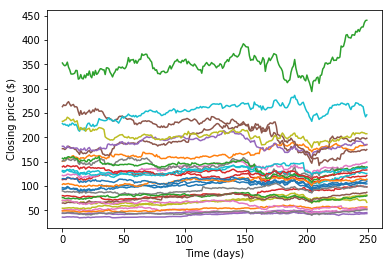

In [4]:
# Extract stock closing prices to a numpy array
data = np.zeros(shape=(m, n))
i = 0
for stock in close_price:
    data[:,i] = close_price[stock]
    plt.plot(np.arange(m), data[:,i])
    i += 1
# Plot closing prices
plt.xlabel('Time (days)')
plt.ylabel('Closing price ($)')
plt.show()

For each stock $i$, we first estimate the $j$th daily relative return as $$relative~return_{i,j} = \frac{closing~price_{i,j+1}-closing~price_{i,j}}{closing~price_{i,j}}.$$

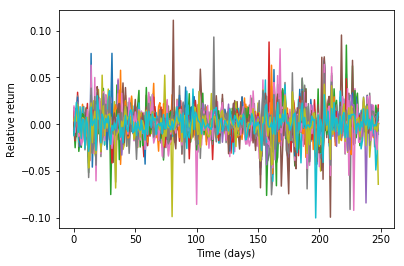

In [5]:
# Relative return
rel_rtn = np.zeros(shape=(m-1, n))
for j in range(m-1):
    rel_rtn[j,:] = np.divide(data[j+1,:] - data[j,:], data[j,:])
# Plot relative return
for i in range(n):
    plt.plot(np.arange(m-1),rel_rtn[:,i])
plt.xlabel('Time (days)')
plt.ylabel('Relative return')
plt.show()

Simply take arithmetic mean of each column of relative return to get mean return $r$ for each stock, followed by estimating covariance $V$ using numpy.

In [6]:
# Mean return
r = np.zeros(n)
r = rel_rtn.sum(axis=0)
r = r / (m-1)
# Covariance matrix
V = np.cov(rel_rtn.T)

# Classic Mean-Variance Model
## Efficient Frontier

One of the major goals of portfolio management is to achieve a certain level of return under a specific risk measurement. Here we demonstrate how to use NAG Library to build efficient frontier by solving classical Markowitz model with long-only constraint (meaning, buy to hold and and short selling is not allowed):
\begin{equation}\label{MV_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+\mu x^TVx\\[0.6ex]
\mbox{subject to} & e^Tx = 1,\\[0.6ex]
     & x\geq0,
\end{array}
\end{equation}
where $e\in\Re^n$ is vector of all ones and $\mu$ is a scalar controling trade-off between return and risk. Note one could build the efficient frontier by varying $\mu$ from $0$ to a certain value.

In [7]:
# Import the NAG Library
from naginterfaces.base import utils
from naginterfaces.library import opt
from naginterfaces.library import lapackeig
# Import necessary math libraries
from scipy.sparse import coo_matrix
import math as mt
import warnings as wn

To solve Problem (\ref{MV_model}) via SOCP, we need to transform it to the standard formulation (\ref{SOCP}) and feed the NAG SOCP solver with data $A$, $l_A$, $u_A$, $c$, $l_x$, $u_x$ and $\cal K$. This modelling process is essential to the usage of SOCP. Getting familiar with these reformulation techniques would unleash the maximum power of SOCP.

To manage the data that the solver requires, one could create and maintain a dictionary structure.

In [8]:
def model_init(n):
    """
    Initialize a dict to store the data that is used to feed NAG socp solver
    """
    model = {
#        Number of variables
         'n': n,
#        Number of constraints
         'm': 0,
#        Coefficient in objective
         'c': np.full(n, 0.0, float),
#        Bound constraints on variables
         'blx': np.full(n, -1.e20, float),
         'bux': np.full(n, 1.e20, float),
#        Coefficient in linear constraints and their bounds
         'linear': {'bl': np.empty(0, float),
                    'bu': np.empty(0, float),
                    'irowa': np.empty(0, int),
                    'icola': np.empty(0, int),
                    'a': np.empty(0, float)},
#        Cone constraint type and variables group
         'cone' : {'type': [],
                   'group': []}
         }
    return model

Once the data in the model has been completed, we could feed the data to the NAG SOCP solver by the following function.

In [9]:
def set_nag(model):
    """
    Use data in model to feed NAG optimization suite to define problm
    """

#   Creat problem handle
    handle = opt.handle_init(model['n'])

#   Set objective function
    opt.handle_set_linobj(handle, model['c'])

#   Set box constraints
    opt.handle_set_simplebounds(handle, model['blx'], model['bux'])

#   Set linear constraints
    opt.handle_set_linconstr(handle, model['linear']['bl'], model['linear']['bu'],
            model['linear']['irowa'], model['linear']['icola'], model['linear']['a'])

#   Set cone constraints
    i = 0
    while i<len(model['cone']['type']):
        opt.handle_set_group(handle,model['cone']['type'][i], 
                             0, model['cone']['group'][i])
        i += 1

#   Set options
    for option in [
            'Print Options = NO',
            'Print Level = 1',
            'Print File = -1',
            'SOCP Scaling = A'
    ]:
        opt.handle_opt_set(handle, option)

    return handle

Now Let's focus on how to get the data in the model ready. In order to add the quadratic objective to the model, we need the following transformation. Note that by introducing variable $t$,
\begin{equation}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+\mu x^TVx
\end{array}
\end{equation}
is equivalent to 
\begin{equation}\label{e_1}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+t\\
\mbox{subject to} & \mu x^TVx\leq t
\end{array}
\end{equation}
when $V$ is positive semidefinite. Now the objective in (\ref{e_1}) is linear which fits into the standard model (\ref{SOCP}). By factorizing $V=F^TF$, one can rewrite the quadratic inequality in (\ref{e_1}) to
$$\label{e_2}
\mu\|Fx\|^2\leq t,
$$
where $\|\cdot\|$ is the Euclidean norm. Note that by introducing $y=Fx$ and $s=\frac{1}{2\mu}$, (\ref{e_2}) can be rewritten as 
$$
\|y\|^2\leq 2st,
$$
which has exactly the same form of cone constraint (\ref{RSOC}). Therefore, the final SOCP formulation of problem (\ref{MV_model}) is
\begin{equation}\label{MV_model_trans}
\begin{array}{ll}
\underset{x\in\Re^n, y\in\Re^n, s\in\Re, t\in\Re}{\mbox{minimize}} & -r^Tx+t\\[0.6ex]
\mbox{subject to} & e^Tx = 1,\\[0.6ex]
     & Fx - y = 0,\\
     & s=\frac{1}{2\mu},\\
     & x\geq0,\\
     & (s,t,y)\in{\cal K}^{n+2}_r.
\end{array}
\end{equation}
Factorization of $V$ can be done using the NAG Library as follows.

In [10]:
def factorize(V):
    """
    For any given positive semidefinite matrix V, factorize it V = F'*F where
    F is kxn matrix that is returned
    """
#   Size of V
    n = V.shape[0]

#   Note one could use sparse factorization if V is input as sparse matrix
    U, lamda = lapackeig.dsyevd('V', 'L', V)

#   Find positive eigenvalues and corresponding eigenvectors
    i = 0
    k = 0
    F = []

    while i<len(lamda):
        if lamda[i] > 0:
            F = np.append(F, mt.sqrt(lamda[i])*U[:,i])
            k += 1
        i += 1

    F = F.reshape((k, n))

    return F

The following code adds a general quadratic objective
\begin{equation}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & \frac{1}{2}x^TVx + q^Tx
\end{array}
\end{equation}
to the model.

In [11]:
def add_qobj(model, F, q=None):
    """
    Add quadratic objective defined as: 1/2 * x'Vx + q'x
    transformed to second order cone by adding artificial variables

    Parameters
    ----------
    model: a dict with structure:
        {
         'n': int,
         'm': int,
         'c': float numpy array,
         'blx': float numpy array,
         'bux': float numpy array,
         'linear': {'bl': float numpy array,
                    'bu': float numpy array,
                    'irowa': int numpy array,
                    'icola': int numpy array,
                    'a': float numpy array},
         'cone' : {'type': character list,
                   'group': nested list of int numpy arrays}
        }
    F: float 2d numpy array
        kxn dense matrix that V = F'*F where k is the rank of V
    q: float 1d numpy array
        n vector

    Returns
    -------
    model: modified structure of model

    Note: imput will not be checked
    """

#   Get the dimension of F (kxn)
    k, n = F.shape

#   Default q
    if q is None:
        q = np.zeros(n)

#   Up-to-date problem size
    m_up = model['m']
    n_up = model['n']

#   Then k + 2 more variables need to be added together with
#   k + 1 linear constraints and a rotated cone contraint
#   Enlarge the model
    model['n'] = model['n'] + k + 2
    model['m'] = model['m'] + k + 1

#   Initialize c in the objective
#   The order of variable is [x, t, y, s]
    model['c'][0:n] = q
    model['c'] = np.append(model['c'], np.zeros(k+2))
    model['c'][n_up] = 1.0

#   Enlarge bounds on x, add inf bounds on the new added k+2 variables
    model['blx'] = np.append(model['blx'], np.full(k+2, -1.e20, dtype=float))
    model['bux'] = np.append(model['bux'], np.full(k+2, 1.e20, dtype=float))

#   Enlarge linear constraints
#   Get the aparsity pattern of F
    row, col = np.nonzero(F)
    val = F[row, col]

#   Convert to 1-based and move row down by m
    row = row + 1 + m_up
    col = col + 1
#   Add coefficient of y, t and s to the existing linear coefficient A
#   The result is
#                  [A, 0,  0, 0;
#                   F, 0, -I, 0;
#                   0, 0,  0, 1]
    row = np.append(row, np.arange(m_up+1, m_up+k+1+1))
    col = np.append(col, np.arange(n_up+2, n_up+k+1+1+1))
    val = np.append(val, np.append(np.full(k, -1.0, dtype=float), 1.0))
    model['linear']['irowa'] = np.append(model['linear']['irowa'], row)
    model['linear']['icola'] = np.append(model['linear']['icola'], col)
    model['linear']['a'] = np.append(model['linear']['a'], val)

    model['linear']['bl'] = np.append(model['linear']['bl'], 
                                      np.append(np.zeros(k), 1.0))
    model['linear']['bu'] = np.append(model['linear']['bu'], 
                                      np.append(np.zeros(k), 1.0))

#   Enlarge cone constraints
    model['cone']['type'].extend('R')
    group = np.zeros(k+2, dtype=int)
    group[0] = n_up + 1
    group[1] = n_up + 1 + k + 1
    group[2:] = np.arange(n_up+2, n_up+k+1+1)
    model['cone']['group'].append(group)

    return model

Note that in the above function, we require the input to be the factor of V instead of V because of two reasons:
\begin{itemize}
\item In some cases, this factorization is already avaliable or easy to compute from the user, for example, when user is using factor-based expected returns, risk and correlations, he should already have $V = B*CF*B^T + \mbox{Diag}(rv)$, then a factorization is a decomposition of a much smaller matrix CF (factor covariance).
\item In many cases, V is not changing during modifications of models, for example, when adding $1/2 * \mu * x^TVx + q^Tx$ with different $\mu$, users do not need to factorize V every time they change $\mu$.
\end{itemize}
Once the objective of (\ref{MV_model}) has been added, we could use the following function to add the long-only constraint$$e^Tx=1~\mbox{and}~x\geq0.$$

In [12]:
def add_longonlycon(model, n, b=None):
    """
    Add long-only constraint to model
    If no b (benchmark) presents, add sum(x) = 1, x >= 0
    If b presents, add sum(x) = 0, x + b >= 0
    """
#   Up-to-date problem size
    m = model['m']

#   No of constraints increased by 1
    model['m'] = model['m'] + 1

#   Bound constraint: x >=0 or x >= -b
    if b is not None:
        model['blx'][0:n] = -b
    else:
        model['blx'][0:n] = np.zeros(n)

#   Linear constraint: e'x = 1 or e'x = 0
    if b is not None:
        model['linear']['bl'] = np.append(model['linear']['bl'], 
                                          np.full(1, 0.0, dtype=float))
        model['linear']['bu'] = np.append(model['linear']['bu'], 
                                          np.full(1, 0.0, dtype=float))
    else:
        model['linear']['bl'] = np.append(model['linear']['bl'], 
                                          np.full(1, 1.0, dtype=float))
        model['linear']['bu'] = np.append(model['linear']['bu'], 
                                          np.full(1, 1.0, dtype=float))

    model['linear']['irowa'] = np.append(model['linear']['irowa'], 
                                         np.full(n, m+1, dtype=int))
    model['linear']['icola'] = np.append(model['linear']['icola'], 
                                         np.arange(1, n+1))
    model['linear']['a'] = np.append(model['linear']['a'], 
                                     np.full(n, 1.0, dtype=float))

    return model

By using the functions above, we can easily build the efficient frontier as follows.

In [13]:
def ef_lo_basic(n, r, V, step=None):
    """
    Basic model to build efficient frontier with long-only constraint
    by solving:
        min -r'*x + mu * x'Vx
        s.t. e'x = 1, x >= 0
    Parameters
    ----------
    n: number of assets
    r: expected return
    V: covariance matrix
    step: define smoothness of the curve of efficient frontier,
          mu would be generated from [0, 2000] with step in default

    Output:
    -------
    risk: a vector of risk sqrt(x'Vx) with repect to certain mu
    rtn: a vector of expected return r'x with repect to certain mu
    """

#   Set optional argument
    if step is None:
        step = 2001

#   Factorize V for just one time, use the factorization in the rest of the code
#   Eigenvalue decomposition on dense V = U*Diag(lamda)*U' to get V = F'*F
    F = factorize(V)

    risk = np.empty(0, float)
    rtn = np.empty(0, float)

    for mu in np.linspace(0.0, 2000.0, step):
#       Initialize a data structure for build the model
        model = model_init(n)
    
#       Quadratic objective function
        muf = F * mt.sqrt(2.0*mu)

        model = add_qobj(model, muf, -r)

#       Add long-only constraint
        model = add_longonlycon(model, n)

#       Now use model to feed NAG socp solver
        handle = set_nag(model)

#       Call socp interior point solver
#       Mute warnings and do not count results from warnings
        wn.simplefilter('error', utils.NagAlgorithmicWarning)
        try:
            slt = opt.handle_solve_socp_ipm(handle)

#           Compute risk and return from the portfolio
            risk = np.append(risk, mt.sqrt(slt.x[0:n].dot(V.dot(slt.x[0:n]))))
            rtn = np.append(rtn, r.dot(slt.x[0:n]))
        except utils.NagAlgorithmicWarning:
            pass
    
#       Destroy the handle:
        opt.handle_free(handle)

    return risk, rtn

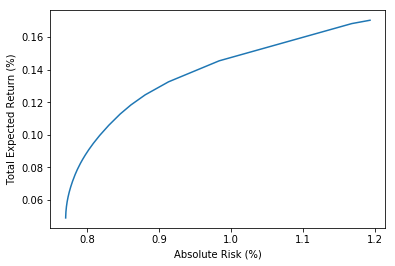

In [14]:
# Build efficient frontier and plot the result
ab_risk, ab_rtn = ef_lo_basic(n, r, V, 500)
plt.plot(ab_risk*100.0, ab_rtn*100.0)
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.show()

## Maximizing the Sharpe ratio

The Sharpe ratio is defined as the ratio of return of portfolio and standard deviation of the portfolio's excess return. It is usually used to measure the efficiency of a portfolio. Find the most efficient portfolio is equivalent to solve the following optimization problem.
\begin{equation}\label{sr_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & \frac{\sqrt{x^TVx}}{r^Tx}\\[0.6ex]
\mbox{subject to} & e^Tx = 1,\\[0.6ex]
     & x\geq0.
\end{array}
\end{equation}
By replacing $x$ with $\frac{y}{\lambda}, \lambda\gt0$, model (\ref{sr_model}) is equivalent to
\begin{equation}\label{sr_model_eq}
\begin{array}{ll}
\underset{y\in\Re^n, \lambda\in\Re}{\mbox{minimize}} & y^TVy\\[0.6ex]
\mbox{subject to} & e^Ty = \lambda,\\[0.6ex]
     & r^Ty=1, \\
     & y\geq0, \\
     & \lambda\geq0.
\end{array}
\end{equation}
Problem (\ref{sr_model_eq}) is similar to problem (\ref{MV_model}) in the sense that they both have a quadratic objective function and linear constraints. We could reuse most of the functions above since the reformulation is almost the same except for the definition of linear constraints. For that purpose, we need to following function.

In [15]:
def add_sr_lincon(model, r, n):
    """
    Add linear constraints for Sharpe ratio problem
    e'y = lamda, y >= 0, r'y = 1, lamda >= 0
    Enlarge model by 1 more variable lamda
    Return: model and index of lambda in the final result, need it to
            reconstruct the original solution
    """
#   Up-to-date problem size
    m_up = model['m']
    n_up = model['n']

#   Add one more var and two more linear constraints
    model['n'] = model['n'] + 1
    model['m'] = model['m'] + 2

#   Enlarge c by one parameter 0.0
    model['c'] = np.append(model['c'], 0.0)

#   Bounds constraints on y
    model['blx'][0:n] = np.zeros(n)

#   Set bound constraints on lamda
    model['blx'] = np.append(model['blx'], 0.0)
    model['bux'] = np.append(model['bux'], 1.e20)

#   Add e'y = lamda
    row = np.full(n+1, m_up+1, dtype=int)
    col = np.append(np.arange(1, n+1), n_up+1)
    val = np.append(np.full(n, 1.0, dtype=float), -1.0)

#   Add r'y = 1
    row = np.append(row, np.full(n, m_up+2, dtype=int))
    col = np.append(col, np.arange(1, n+1))
    val = np.append(val, r)

#   Update model
    model['linear']['irowa'] = np.append(model['linear']['irowa'], row)
    model['linear']['icola'] = np.append(model['linear']['icola'], col)
    model['linear']['a'] = np.append(model['linear']['a'], val)

#   Bounds on linear constraints
    model['linear']['bl'] = np.append(model['linear']['bl'], 
                                      np.append(np.zeros(1), 1.0))
    model['linear']['bu'] = np.append(model['linear']['bu'], 
                                      np.append(np.zeros(1), 1.0))

    return model, n_up

Now we can call the NAG SOCP solver as follows.

In [16]:
def sr_lo_basic(n, r, V):
    """
    Basic model to calculate efficient portfolio that maximize the Sharpe ratio
    min y'Vy
    s.t. e'y = lamda, y >= 0, r'y = 1, lamda >= 0
    Return efficient portfolio y/lamda and corresponding risk and return
    """
#   Factorize V for just one time, use the factorization in the rest of the code
#   Eigenvalue decomposition on dense V = U*Diag(lamda)*U' to get V = F'*F
    F = factorize(V)

#   Initialize a data structure for build the model
    model = model_init(n)

#   Quadratic objective function
    muf = F * mt.sqrt(2.0)

    model = add_qobj(model, muf)

#   Add linear constraints
    model, lamda_idx = add_sr_lincon(model, r, n)

#   Now use model to feed NAG socp solver
    handle = set_nag(model)

#   Call socp interior point solver
    slt = opt.handle_solve_socp_ipm(handle)

    sr_risk = mt.sqrt(slt.x[0:n].dot(V.dot(slt.x[0:n])))/slt.x[lamda_idx]
    sr_rtn = r.dot(slt.x[0:n])/slt.x[lamda_idx]

    return sr_risk, sr_rtn, slt.x[0:n]/slt.x[lamda_idx]

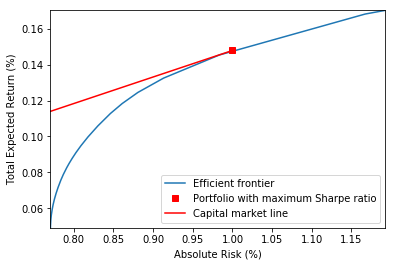

In [17]:
# Compute the most efficient portfolio and plot result.
sr_risk, sr_rtn, sr_x = sr_lo_basic(n, r, V)
plt.plot(ab_risk*100.0, ab_rtn*100.0, label='Efficient frontier')
plt.plot([sr_risk*100], [sr_rtn*100], 'rs', 
         label='Portfolio with maximum Sharpe ratio')
plt.plot([sr_risk*100, 0.0], [sr_rtn*100, 0.0], 'r-', label='Capital market line')
plt.axis([min(ab_risk*100), max(ab_risk*100), min(ab_rtn*100), max(ab_rtn*100)])
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.legend()
plt.show()

# Portfolio optimization with tracking-error constraint

To avoid taking unnecessary risk when beating a benchmark, the investors commonly impose a limit on the volatility of the deviation of the active portfolio from the benchmark, which is also known as tracking-error volatility (TEV) \cite{J03}. The model to build efficient frontier in excess-return space is
\begin{equation}\label{er_tev}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{maximize}} & r^Tx\\
\mbox{subject to} & e^Tx = 0,\\
     & x^TVx\leq tev,
\end{array}
\end{equation}
where $tev$ is a limit on the track-error. Roll \cite{R92} noted that problem (\ref{er_tev}) is totally independent of the benchmark and leads to the unpalatable result that the active portfolio has systematically higher risk than the benchmark and is not optimal. Therefore, in this section we solve a more advanced model by taking absolute risk into account as follows.
\begin{equation}\label{tev_model}
\begin{array}{ll}
\underset{x\in\Re^n}{\mbox{minimize}} & -r^Tx+\mu (x+b)^TV(x+b)\\
\mbox{subject to} & e^Tx = 0,\\
     & x^TVx\leq tev,\\
     & x+b\geq0,
\end{array}
\end{equation}
where $b$ is a benchmark portfolio. In this demonstration, it is generated synthetically. Note here we use the same covariance matrix $V$ for tev and absolute risk measurement for demonstration purpose. In practice one could use different covariance matrices from different markets.

In [18]:
# Generate a benchmark portfolio from efficient portfolio that 
# maximizes the Sharpe ratio
# Perturb x
b = sr_x + 1.e-1
# Normalize b
b = b/sum(b)

# Compute risk and return at the benchmark
b_risk = mt.sqrt(b.dot(V.dot(b)))
b_rtn = r.dot(b)

Note that same as in problem (\ref{MV_model}), the objective function in (\ref{tev_model}) is quadratic, so we can use $add\_qobj()$ to add it to the model. But problem (\ref{tev_model}) has a quadratic constraint, which makes it a quadratically constrained quadratic programming (QCQP). Following a similar procedure to the transformation of constraint in (\ref{e_1}), we can write a function that can be reused repeatedly to add general quadratic constraints.

In [19]:
def add_qcon(model, F, q=None, r=None):
    """
    Add quadratic contraint defined as: 1/2 * x'Vx + q'x + r <= 0,
    which is equivalent to t + q'x + r = 0, 1/2 * x'Vx <= t,
    transformed to second order cone by adding artificial variables

    Parameters
    ----------
    model: a dict with structure:
        {
         'n': int,
         'm': int,
         'c': float numpy array,
         'blx': float numpy array,
         'bux': float numpy array,
         'linear': {'bl': float numpy array,
                    'bu': float numpy array,
                    'irowa': int numpy array,
                    'icola': int numpy array,
                    'a': float numpy array},
         'cone' : {'type': character list,
                   'group': nested list of int numpy arrays}
        }
    F: float 2d numpy array
        kxn dense matrix that V = F'*F where k is the rank of V

    q: float 1d numpy array
        n vector

    r: float scalar

    Returns
    -------
    model: modified structure of model

    Note: imput will not be checked
    """
#   Default parameter
    if r is None:
        r = 0.0

#   Get the dimension of F (kxn)
    k, n = F.shape

#   Up-to-date problem size
    m_up = model['m']
    n_up = model['n']

#   Then k + 2 more variables need to be added together with
#   k + 2 linear constraints and a rotated cone contraint
#   Enlarge the model
    model['n'] = model['n'] + k + 2
    model['m'] = model['m'] + k + 2

#   All the added auxiliary variables do not take part in obj
#   So their coeffients in obj are all zeros.
    model['c'] = np.append(model['c'], np.zeros(k+2))

#   Enlarge bounds on x, add inf bounds on the new added k+2 variables
    model['blx'] = np.append(model['blx'], np.full(k+2, -1.e20, dtype=float))
    model['bux'] = np.append(model['bux'], np.full(k+2, 1.e20, dtype=float))

#   Enlarge linear constraints
    row, col = np.nonzero(F)
    val = F[row, col]

#   Convert to 1-based and move row down by m_up
#   Add Fx = y and s = 1
#   [x,t,y,s]
    row = row + 1 + m_up
    col = col + 1
    row = np.append(np.append(row, np.arange(m_up+1, m_up+k+1+1)), m_up+k+1+1)
    col = np.append(np.append(col, np.arange(n_up+2, n_up+k+1+1+1)), n_up+1)
    val = np.append(np.append(val, np.append(np.full(k, -1.0, 
                                                     dtype=float), 1.0)), 1.0)
    model['linear']['irowa'] = np.append(model['linear']['irowa'], row)
    model['linear']['icola'] = np.append(model['linear']['icola'], col)
    model['linear']['a'] = np.append(model['linear']['a'], val)

    model['linear']['bl'] = np.append(np.append(model['linear']['bl'], 
                                                np.append(np.zeros(k), 1.0)), -r)
    model['linear']['bu'] = np.append(np.append(model['linear']['bu'], 
                                                np.append(np.zeros(k), 1.0)), -r)

#   Add t + q'x + r = 0
    if q is not None:
        model['linear']['irowa'] = np.append(model['linear']['irowa'], 
                                             np.full(n, m_up+k+2, dtype=int))
        model['linear']['icola'] = np.append(model['linear']['icola'], 
                                             np.arange(1, n+1))
        model['linear']['a'] = np.append(model['linear']['a'], q)

#   Enlarge cone constraints
    model['cone']['type'].extend('R')
    group = np.zeros(k+2, dtype=int)
    group[0] = n_up + 1
    group[1] = n_up + 1 + k + 1
    group[2:] = np.arange(n_up+2, n_up+k+1+1)
    model['cone']['group'].append(group)

    return model

By using the function above, we can easily build the efficient frotier with TEV constraint as follows.

In [20]:
def tev_lo(n, r, V, b, tev, step=None):
    """
    TEV contrained portforlio optimization with absolute risk taken into
    consideration by solving:
    min -r'y + mu*(b+y)'V(b+y)
    s.t. sum(y) = 0, y+b >=o, y'Vy <= tev
    """
#   Set optional argument
    if step is None:
        step = 2001

#   Factorize V for just one time, use the factorization in the rest of the code
#   Eigenvalue decomposition on dense V = U*Diag(lamda)*U' to get V = F'*F
    F = factorize(V)

    risk = np.empty(0, float)
    rtn = np.empty(0, float)

    for mu in np.linspace(0.0, 2000.0, step):
#       Initialize a data structure for build the model
        model = model_init(n)

#       Add long-only constraint
        model = add_longonlycon(model, n, b)

#       Quadratic objective function
        muf = F * mt.sqrt(2.0*mu)
        mur = 2.0*mu*V.dot(b) - r

        model = add_qobj(model, muf, mur)

#       Add Quadratic constraint y'Vy <= tev
        F_hf = F * mt.sqrt(2.0)
        model = add_qcon(model, F_hf, r=-tev)

#       Now use model to feed NAG socp solver
        handle = set_nag(model)

#       Call socp interior point solver
#       Mute warnings and do not count results from warnings
        wn.simplefilter('error', utils.NagAlgorithmicWarning)
        try:
            slt = opt.handle_solve_socp_ipm(handle)

#           Compute risk and return from the portfolio
            risk = np.append(risk, mt.sqrt((slt.x[0:n]+b).dot(V.dot(slt.x[0:n]+b))))
            rtn = np.append(rtn, r.dot(slt.x[0:n]+b))
        except utils.NagAlgorithmicWarning:
            pass
    
#       Destroy the handle:
        opt.handle_free(handle)

    return risk, rtn

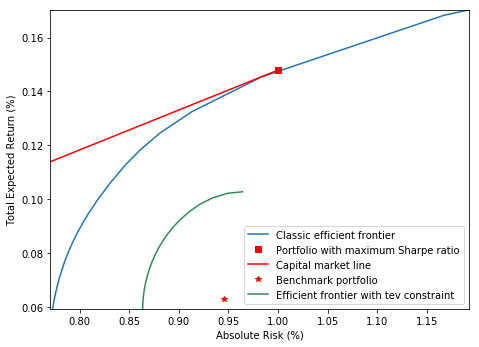

In [21]:
# Set limit on tracking-error
tev = 0.000002
# Solve the model
tev_risk, tev_rtn = tev_lo(n, r, V, b, tev, step=500)
# Plot the result
plt.figure(figsize=(7.5, 5.5))
plt.plot(ab_risk*100.0, ab_rtn*100.0, label='Classic efficient frontier')
plt.plot([sr_risk*100], [sr_rtn*100], 'rs', 
         label='Portfolio with maximum Sharpe ratio')
plt.plot([sr_risk*100, 0.0], [sr_rtn*100, 0.0], 'r-', label='Capital market line')
plt.plot(b_risk*100, b_rtn*100, 'r*', label='Benchmark portfolio')
plt.plot(tev_risk*100.0, tev_rtn*100.0, 'seagreen', 
         label='Efficient frontier with tev constraint')

plt.axis([min(ab_risk*100), max(ab_risk*100), min(tev_rtn*100), max(ab_rtn*100)])
plt.ylabel('Total Expected Return (%)')
plt.xlabel('Absolute Risk (%)')
plt.legend()
plt.show()

# Conclusion

In this notebook, we demonstrated how to use NAG Library to solve various models in portfolio optimization. One could take some of the functions mentioned above and start to build their own model immediately. It is worth pointing out that the versatility of SOCP is not just limited to the models mentioned here. It covers a lot more problems and constraints. For example, DeMiguel et al. \cite{DGNU09} discussed portfolio optimization with norm constraint, which can be easily transformed into an SOCP problem. We refer readers to the NAG Library documentation \cite{NAGDOC} on SOCP solver and \cite{AG03, LVBL98} for more details.

# References

[<a id="cit-AG03" href="#call-AG03">1</a>] Alizadeh Farid and Goldfarb Donald, ``_Second-order cone programming_'', Mathematical programming, vol. 95, number 1, pp. 3--51,  2003.

[<a id="cit-LVBL98" href="#call-LVBL98">2</a>] Lobo Miguel Sousa, Vandenberghe Lieven, Boyd Stephen <em>et al.</em>, ``_Applications of second-order cone programming_'', Linear algebra and its applications, vol. 284, number 1-3, pp. 193--228,  1998.

[<a id="cit-J03" href="#call-J03">3</a>] Jorion Philippe, ``_Portfolio optimization with tracking-error constraints_'', Financial Analysts Journal, vol. 59, number 5, pp. 70--82,  2003.

[<a id="cit-R92" href="#call-R92">4</a>] Roll Richard, ``_A mean/variance analysis of tracking error_'', The Journal of Portfolio Management, vol. 18, number 4, pp. 13--22,  1992.

[<a id="cit-DGNU09" href="#call-DGNU09">5</a>] DeMiguel Victor, Garlappi Lorenzo, Nogales Francisco J <em>et al.</em>, ``_A generalized approach to portfolio optimization: Improving performance by constraining portfolio norms_'', Management science, vol. 55, number 5, pp. 798--812,  2009.

[<a id="cit-NAGDOC" href="#call-NAGDOC">6</a>] Numerical Algorithms Group, ``_NAG documentation_'',  2019.  [online](https://www.nag.co.uk/numeric/fl/nagdoc_latest/html/frontmatter/manconts.html)

